<a href="https://colab.research.google.com/github/Fitranda/Dokumen/blob/master/Padi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Langkah 1: Hubungkan Google Colab dengan Google Drive Anda
from google.colab import drive
drive.mount('/content/drive')

# Langkah 2: Impor library untuk proses unzip
import zipfile

# Langkah 3: Tentukan lokasi file zip Anda di Google Drive
# PERHATIKAN: Pastikan Anda menyesuaikan path ini jika berbeda.
zip_path = '/content/drive/MyDrive/Citra Padi/archive.zip' # Contoh: Periksa kapitalisasi 'Citra Padi'

# Langkah 4: Tentukan di folder mana Anda ingin menyimpan hasil ekstrak
# Kode ini akan membuat folder baru bernama 'dataset_padi' di Colab untuk menyimpan hasilnya.
extract_path = '/content/dataset_padi/'

# Langkah 5: Proses ekstraksi file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"File berhasil diekstrak ke folder: {extract_path}")

# (Opsional) Langkah 6: Tampilkan daftar file yang sudah diekstrak untuk verifikasi
import os
print("\nIsi folder hasil ekstrak:")
print(os.listdir(extract_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File berhasil diekstrak ke folder: /content/dataset_padi/

Isi folder hasil ekstrak:
['RiceLeafs', 'riceleafs']


COBA COBA Augmentasi Data dengan ImageDataGenerator

Found 2684 images belonging to 4 classes.
Found 671 images belonging to 4 classes.
Contoh hasil augmentasi dari training generator:


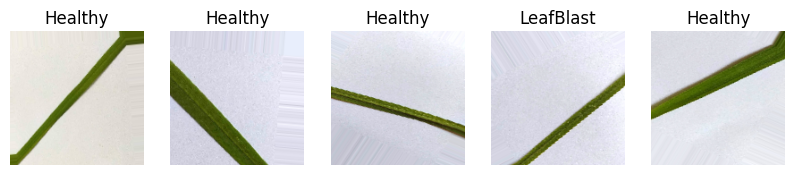

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Tentukan path ke direktori dataset Anda yang sudah diekstrak
# Folder /content/dataset_padi/ adalah tempat kita mengekstrak file di langkah sebelumnya
base_dir = '/content/dataset_padi/RiceLeafs'
train_dir = f'{base_dir}/train'
validation_dir = f'{base_dir}/validation'

# 1. Membuat ImageDataGenerator untuk augmentasi data training
# Kita akan melakukan beberapa transformasi: rotasi, pergeseran, zoom, dan flip horizontal.
# rescale=1./255 adalah untuk normalisasi nilai piksel dari [0, 255] menjadi [0, 1].
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 2. Membuat ImageDataGenerator untuk data validasi
# PENTING: Jangan augmentasi data validasi, kita hanya perlu normalisasi pikselnya.
validation_datagen = ImageDataGenerator(rescale=1./255)

# 3. Menyiapkan data generator dari direktori
# Generator akan membaca gambar dari subfolder dan secara otomatis memberi label sesuai nama subfolder.
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Mengubah ukuran semua gambar menjadi 150x150 piksel
    batch_size=32,
    class_mode='categorical'  # Karena kita punya lebih dari 2 kelas
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# 4. (Opsional) Visualisasi hasil augmentasi
print("Contoh hasil augmentasi dari training generator:")
# Ambil satu batch gambar
images, labels = next(train_generator)

# Tampilkan 5 gambar pertama dari batch tersebut
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    # Dapatkan nama kelas dari label one-hot encoding
    class_name = list(train_generator.class_indices.keys())[np.argmax(labels[i])]
    plt.title(class_name)
    plt.axis('off')
plt.show()

Augmentasi -> ekstrasi menggunakan histogram warna -> klasifikasi menggunakan random forest


In [4]:
# =============================================================================
# BAGIAN -1: PERSIAPAN & KONEKSI KE GOOGLE DRIVE
# =============================================================================
import os
import shutil
import cv2
import numpy as np
import collections
import time
import joblib # Library untuk menyimpan model
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# Hubungkan ke Google Drive
drive.mount('/content/drive')

# Buat folder utama di Drive untuk menyimpan semua hasil
save_dir_drive = '/content/drive/MyDrive/HasilKlasifikasiPadi'
os.makedirs(save_dir_drive, exist_ok=True)
print(f"Semua hasil akan disimpan di: {save_dir_drive}")

# =============================================================================
# BAGIAN 0: PERSIAPAN DIREKTORI LOKAL DAN ANALISIS DATA
# =============================================================================

# Tentukan path direktori sumber
base_dir = '/content/dataset_padi/RiceLeafs'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Buat direktori baru di Colab untuk data training yang seimbang
balanced_train_dir = '/content/train_balanced'
if os.path.exists(balanced_train_dir):
    shutil.rmtree(balanced_train_dir)
os.makedirs(balanced_train_dir)

# Hitung jumlah gambar di setiap kelas
class_counts = {c: len(os.listdir(os.path.join(train_dir, c))) for c in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, c))}
print("\nJumlah gambar per kelas (sebelum balancing):", class_counts)

target_count = max(class_counts.values())
print(f"Target jumlah gambar per kelas: {target_count}")

# =============================================================================
# BAGIAN 1: PROSES AUGMENTASI OFFLINE UNTUK BALANCING
# =============================================================================

datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
print("\nMemulai proses augmentasi untuk menyeimbangkan dataset...")

for class_name, count in class_counts.items():
    original_class_path = os.path.join(train_dir, class_name)
    balanced_class_path = os.path.join(balanced_train_dir, class_name)
    os.makedirs(balanced_class_path, exist_ok=True)

    # Salin gambar asli
    for filename in os.listdir(original_class_path):
        shutil.copy(os.path.join(original_class_path, filename), balanced_class_path)

    # Lakukan augmentasi jika perlu
    num_to_generate = target_count - count
    if num_to_generate > 0:
        print(f"Augmentasi kelas '{class_name}': Menghasilkan {num_to_generate} gambar baru...")
        image_files = os.listdir(original_class_path)
        for i in tqdm(range(num_to_generate)):
            random_image_name = np.random.choice(image_files)
            img = load_img(os.path.join(original_class_path, random_image_name))
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)
            for batch in datagen.flow(x, batch_size=1, save_to_dir=balanced_class_path, save_prefix=f'aug_{class_name}', save_format='jpg'):
                break

print("\nProses balancing selesai.")

# --- SIMPAN HASIL AUGMENTASI KE DRIVE ---
drive_augmented_path = os.path.join(save_dir_drive, 'train_balanced_augmented')
if os.path.exists(drive_augmented_path):
    shutil.rmtree(drive_augmented_path) # Hapus folder lama jika ada
shutil.copytree(balanced_train_dir, drive_augmented_path)
print(f"✅ Folder hasil augmentasi berhasil disimpan ke: {drive_augmented_path}")

# =============================================================================
# BAGIAN 2: EKSTRAKSI FITUR HISTOGRAM
# =============================================================================

def extract_color_histogram(image_path, bins=(8, 8, 8)):
    image = cv2.imread(image_path)
    if image is None: return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def load_data_and_extract_features(directory):
    features, labels = [], []
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path): continue
        for image_name in tqdm(os.listdir(class_path), desc=f'Ekstrak Fitur Kelas: {class_name}'):
            hist = extract_color_histogram(os.path.join(class_path, image_name))
            if hist is not None:
                features.append(hist)
                labels.append(class_name)
    return np.array(features), np.array(labels)

print("\nMemulai ekstraksi fitur dari dataset...")
X_train, y_train = load_data_and_extract_features(balanced_train_dir)
X_val, y_val = load_data_and_extract_features(validation_dir)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# --- SIMPAN HASIL FITUR HISTOGRAM KE DRIVE ---
features_path = os.path.join(save_dir_drive, 'fitur_histogram.npz')
np.savez_compressed(features_path,
                    X_train=X_train, y_train=y_train_encoded,
                    X_val=X_val, y_val=y_val_encoded,
                    labels_map=label_encoder.classes_)
print(f"✅ Fitur histogram berhasil disimpan ke: {features_path}")

# =============================================================================
# BAGIAN 3: TRAINING & EVALUASI MODEL RANDOM FOREST
# =============================================================================

print("\nMemulai pelatihan model Random Forest...")
model_rf = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train_encoded)
print("Pelatihan model selesai.")

# --- SIMPAN MODEL YANG SUDAH DILATIH KE DRIVE ---
model_path = os.path.join(save_dir_drive, 'random_forest_model.joblib')
joblib.dump(model_rf, model_path)
print(f"✅ Model berhasil disimpan ke: {model_path}")

# --- EVALUASI MODEL ---
print("\n--- HASIL EVALUASI MODEL ---")
predictions = model_rf.predict(X_val)
accuracy = accuracy_score(y_val_encoded, predictions)
print(f"Akurasi Model pada Data Validasi: {accuracy * 100:.2f}%\n")
print("Laporan Klasifikasi Lengkap:")
print(classification_report(y_val_encoded, predictions, target_names=label_encoder.classes_))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Semua hasil akan disimpan di: /content/drive/MyDrive/HasilKlasifikasiPadi

Jumlah gambar per kelas (sebelum balancing): {'BrownSpot': 418, 'Healthy': 1191, 'LeafBlast': 623, 'Hispa': 452}
Target jumlah gambar per kelas: 1191

Memulai proses augmentasi untuk menyeimbangkan dataset...
Augmentasi kelas 'BrownSpot': Menghasilkan 773 gambar baru...


100%|██████████| 773/773 [18:11<00:00,  1.41s/it]


Augmentasi kelas 'LeafBlast': Menghasilkan 568 gambar baru...


100%|██████████| 568/568 [09:35<00:00,  1.01s/it]


Augmentasi kelas 'Hispa': Menghasilkan 739 gambar baru...


100%|██████████| 739/739 [17:19<00:00,  1.41s/it]



Proses balancing selesai.
✅ Folder hasil augmentasi berhasil disimpan ke: /content/drive/MyDrive/HasilKlasifikasiPadi/train_balanced_augmented

Memulai ekstraksi fitur dari dataset...


Ekstrak Fitur Kelas: LeafBlast: 100%|██████████| 156/156 [00:05<00:00, 27.13it/s]


✅ Fitur histogram berhasil disimpan ke: /content/drive/MyDrive/HasilKlasifikasiPadi/fitur_histogram.npz

Memulai pelatihan model Random Forest...
Pelatihan model selesai.
✅ Model berhasil disimpan ke: /content/drive/MyDrive/HasilKlasifikasiPadi/random_forest_model.joblib

--- HASIL EVALUASI MODEL ---
Akurasi Model pada Data Validasi: 14.61%

Laporan Klasifikasi Lengkap:
              precision    recall  f1-score   support

   BrownSpot       0.17      0.37      0.23       105
     Healthy       0.38      0.08      0.13       297
       Hispa       0.39      0.11      0.17       113
   LeafBlast       0.07      0.15      0.09       156

    accuracy                           0.15       671
   macro avg       0.25      0.18      0.16       671
weighted avg       0.28      0.15      0.14       671

